# Evaluation of A Model

This notebook is intended to bee used for evaluation of a trained model over test dataset. Please change the config dictionary in the begening so that you can evaluate your desired model/sample etc...

In [1]:
#configure your evalutaion parameters here
_config = {
    'batch_size':1,
    'input_shape_height' : 375,
    'input_shape_width' : 262,
    'model_filename' : 'output/resnet_classification/resnet.h5',
    'test_sample_filename' : 'data/test/00000000a9764df2_20191005_085442_4.png'
}

In [2]:
#If you want to disable GPU uncomment here
#import os 
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

---
This section is core global variables to be used during evalutaion

In [3]:
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.metrics import Precision,Recall,MeanIoU,TruePositives,TrueNegatives,FalsePositives,FalseNegatives
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from helpers.overallperformance import OverallPerformance
from keras.applications.resnet_v2 import preprocess_input

physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    _ = tf.config.experimental.set_memory_growth(physical_devices[0], True)

df_train =  pd.read_csv('data/train_labels.csv')
df_test =  pd.read_csv('data/test_labels.csv')

from helpers.decouple import decouple
matrix_test,classes_test = decouple(df_test)
matrix_train,classes_train = decouple(df_train)
from helpers.matrix_to_df import matrix_to_df
df_test_agg = matrix_to_df(matrix_test)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_dataframe(
        dataframe=df_test_agg,
        directory='data/test',
        x_col='filename',
        y_col='class',
        target_size=(_config['input_shape_height'], _config['input_shape_width']),
        batch_size=_config['batch_size'],
        class_mode='categorical')

model = load_model(_config['model_filename'],compile=False)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',Precision(),Recall(),MeanIoU(40),TruePositives(),TrueNegatives(),FalsePositives(),FalseNegatives(),OverallPerformance()])

Using TensorFlow backend.
Found 505 validated image filenames belonging to 40 classes.


---
This section is intented to see overrall performance of the model on the entire test dataset.

In [4]:
#I have spent time for this code but it is useless. I try to get the total number of objects for each class in all test set with two different results, ground truth and prerdictions. And then tried to confusion report them which is dull.

#result = model.predict_generator(test_generator)
#result.shape

#prerdiction_counts = np.sum(np.round(result),axis=0)
#prerdiction_counts = prerdiction_counts.astype(int)
#prerdiction_counts

#ground_truths = np.zeros(len(list(test_generator.class_indices.keys())))
#for i in range(len(test_generator)):
#    img_batch,ground_truth = test_generator.next()
#    ground_truths = np.sum([ground_truths,ground_truth[0]],axis=0)
#ground_truths = ground_truths.astype(int)
#ground_truths

#from sklearn.metrics import classification_report
#target_names = list(test_generator.class_indices.keys())
#report = classification_report(ground_truths,prerdiction_counts,labels=target_names,target_names=target_names)
#print(report)

The following cell evaluates the model on a test dataset that has never seen before during training. 

In [5]:
model.evaluate_generator(test_generator)

[0.08956097066402435,
 0.9670811295509338,
 0.9251213669776917,
 0.9068136215209961,
 0.5468288660049438,
 3620.0,
 15915.0,
 293.0,
 372.0,
 0.8448074460029602]

The following two cells tries to construct confusion matrix for each class/product. First cell populates the all sample's ground truths and predictions in respective numpy arrays. The second cell calls the multilabel_confusion_matrix method of sklearn moodule and plots the results for each class. 

To explain the plot in detail:
- every class/product label has a percantage nerby which is the accuracy of the particular confusion matrix.
- The percantage written in row 0 column 1 is precision
- The percantage written in row 1 column 0 is recall
- The percantage written in row 1 column 1 is mean IOU

In [6]:
ground_truths = []
predictions = []
for i in range(len(test_generator)):
    img_batch,ground_truth = test_generator.next()
    ground_truths.append(ground_truth[0].astype(int))
    prediction = model.predict(img_batch)
    predictions.append(np.round(prediction[0]))
ground_truths = np.array(ground_truths,dtype=int)
predictions = np.array(predictions,dtype=int)
print(ground_truths.shape)
print(predictions.shape)

(505, 40)
(505, 40)


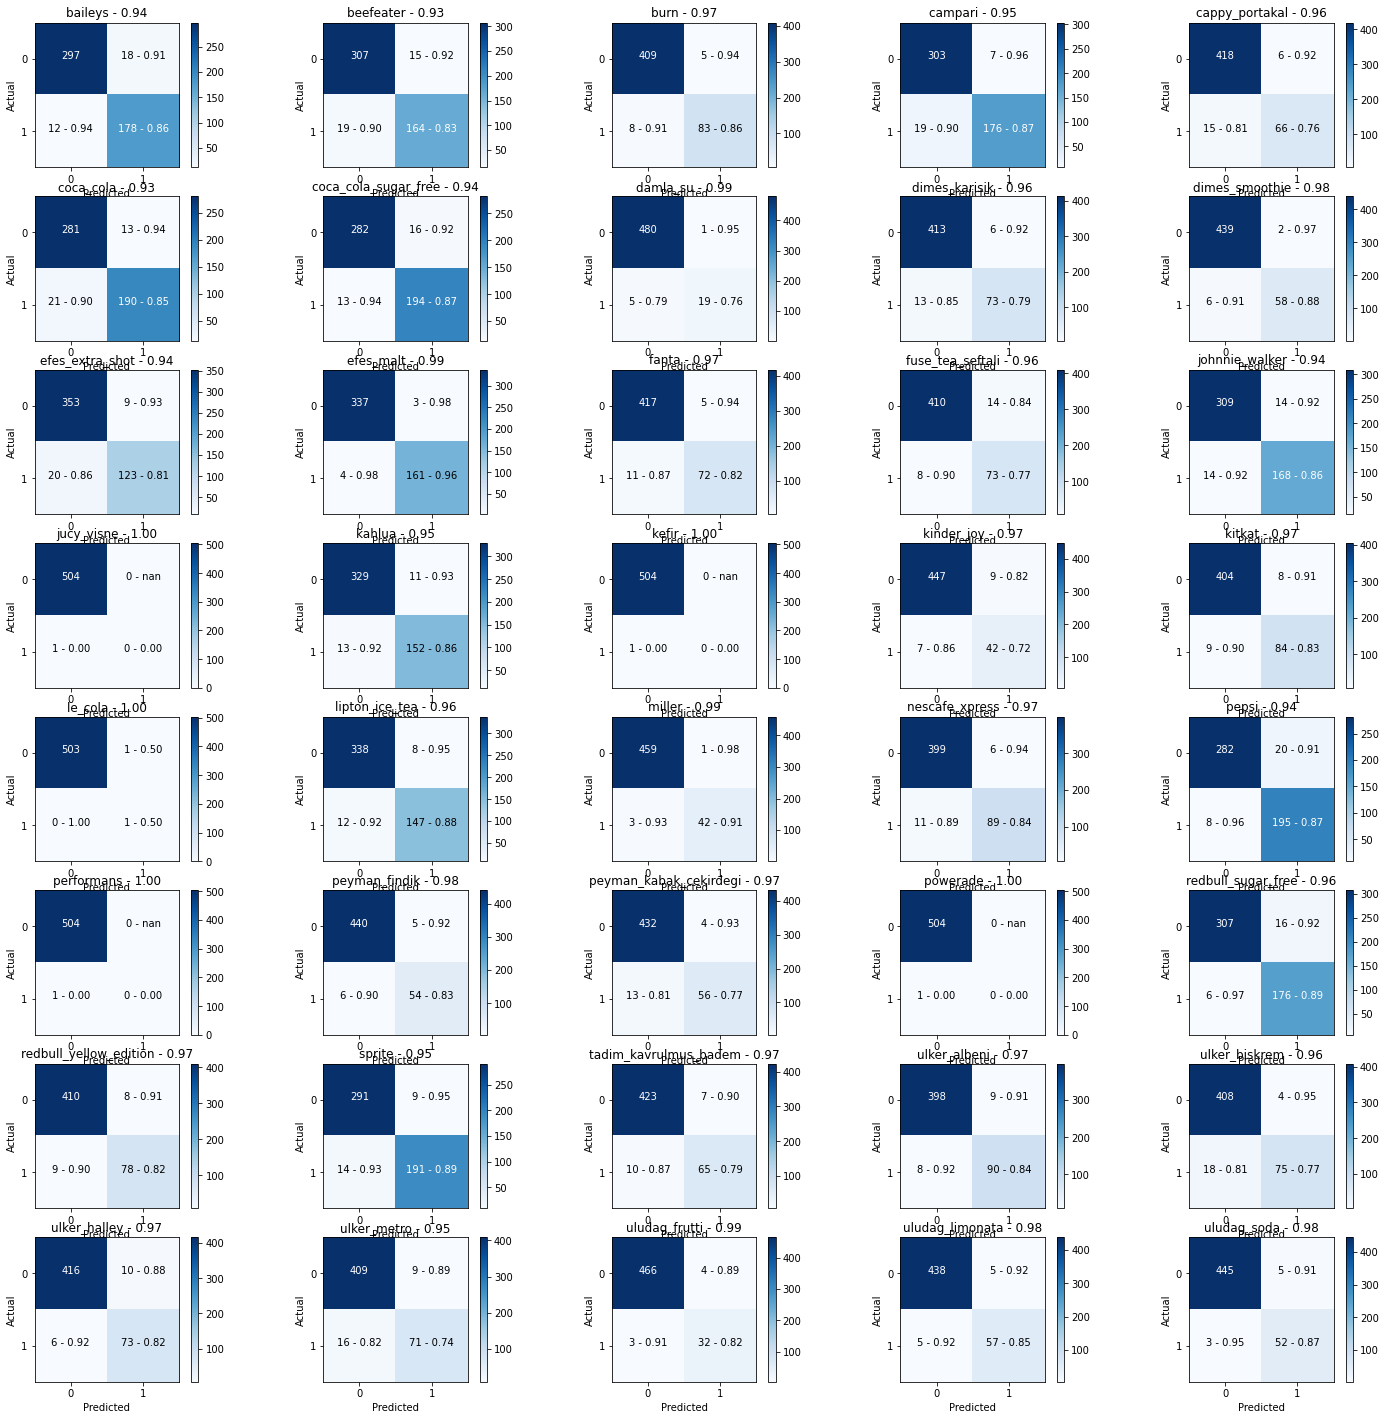

In [7]:
from sklearn.metrics import multilabel_confusion_matrix
cms = multilabel_confusion_matrix(ground_truths, predictions)
cm_all = np.zeros((2,2))

labels = list(test_generator.class_indices.keys())
fig=plt.figure(figsize=(25, 25))
columns = 5
rows = 8
report = []
for r in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, r)
    cm = cms[r-1]
    acc = (cm[0,0]+cm[1,1])/(cm[0,0]+cm[1,1]+cm[0,1]+cm[1,0])
    recall = cm[1,1] / (cm[1,1] + cm[1,0])
    precision = cm[1,1] / (cm[1,1] + cm[0,1])
    mean_iou = cm[1,1] / (cm[1,1] + cm[0,1] + cm[1,0])
    train_count = classes_train[labels[r-1]]
    test_count = classes_test[labels[r-1]]
    cm_all[0,0] += cm[0,0]
    cm_all[0,1] += cm[0,1]
    cm_all[1,1] += cm[1,1]
    cm_all[1,0] += cm[1,0]
    report.append({'product':labels[r-1],'accuracy':acc,'recall':recall,'precision':precision,'mean_iou':mean_iou,'train_count':train_count,'test_count':test_count})
    plt.imshow(cm,cmap=plt.cm.Blues,interpolation='nearest')
    plt.colorbar(orientation='vertical')
    plt.title("%s - %.2f"%(labels[r-1],acc))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks([0,1])
    plt.yticks([0,1])
    for i,row in enumerate(cm):
        for j,cell in enumerate(row):
            val_text = "%d"%(cm[i,j])
            if i == 1 and j == 0:
                val_text = "%d - %.2f"%(cm[i,j],recall)
            if i == 0 and j == 1:
                val_text = "%d - %.2f"%(cm[i,j],precision)
            if i == 1 and j == 1:
                val_text = "%d - %.2f"%(cm[i,j],mean_iou)
            plt.text(j,i,val_text,horizontalalignment='center',color='white'if cm[i,j] >cm.max() / 2. else 'black')
plt.show()    

In [8]:
cm_all

array([[15915.,   293.],
       [  372.,  3620.]])

In [9]:
report_data = pd.DataFrame(report)
report_data = report_data.sort_values(by=['mean_iou','recall','precision'])
report_data

,product,accuracy,recall,precision,mean_iou,train_count,test_count
15,jucy_visne,0.998020,0.000000,NaN,0.000000,4,1
17,kefir,0.998020,0.000000,NaN,0.000000,4,1
25,performans,0.998020,0.000000,NaN,0.000000,4,1
28,powerade,0.998020,0.000000,NaN,0.000000,4,1
20,le_cola,0.998020,1.000000,0.500000,0.500000,4,1
18,kinder_joy,0.968317,0.857143,0.823529,0.724138,148,49
36,ulker_metro,0.950495,0.816092,0.887500,0.739583,230,87
4,cappy_portakal,0.958416,0.814815,0.916667,0.758621,199,81
7,damla_su,0.988119,0.791667,0.950000,0.760000,78,24
27,peyman_kabak_cekirdegi,0.966337,0.811594,0.933333,0.767123,183,70


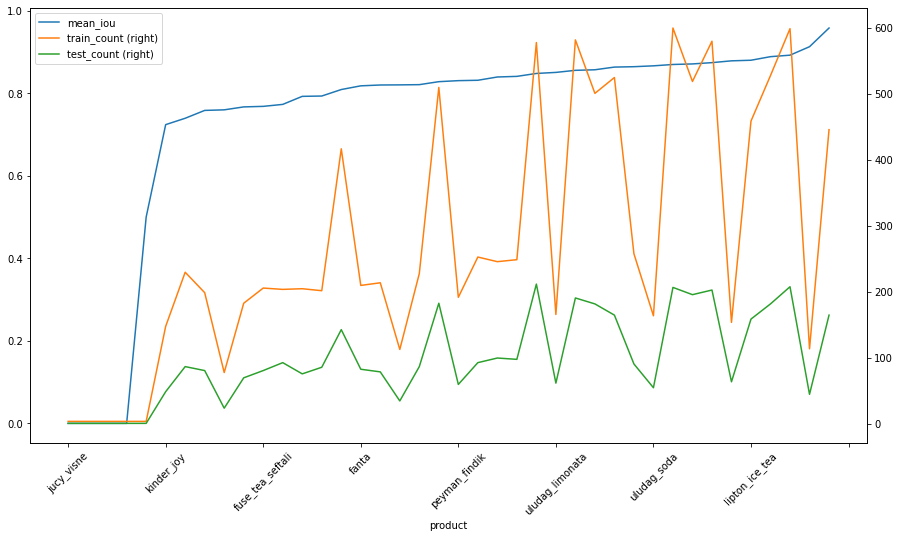

In [10]:
report_data.plot(x='product',y=['mean_iou','train_count','test_count'],figsize=(15,8),rot=45,secondary_y=['train_count','test_count'])

---
This section is working on sinlge sample. If you want to examine and explore a specific image on detail. Change the filename that you want to examine on the config at the begening of the notebook

In [11]:
test_img = image.load_img(_config['test_sample_filename'],target_size=(_config['input_shape_height'], _config['input_shape_width'],3))
test_img = image.img_to_array(test_img)
test_img_visible = test_img/255
test_img = np.expand_dims(test_img,axis=0)
test_img = preprocess_input(test_img)
prediction = model.predict(test_img)

print(list(test_generator.class_indices.keys()))
print(prediction[0])

['baileys', 'beefeater', 'burn', 'campari', 'cappy_portakal', 'coca_cola', 'coca_cola_sugar_free', 'damla_su', 'dimes_karisik', 'dimes_smoothie', 'efes_extra_shot', 'efes_malt', 'fanta', 'fuse_tea_seftali', 'johnnie_walker', 'jucy_visne', 'kahlua', 'kefir', 'kinder_joy', 'kitkat', 'le_cola', 'lipton_ice_tea', 'miller', 'nescafe_xpress', 'pepsi', 'performans', 'peyman_findik', 'peyman_kabak_cekirdegi', 'powerade', 'redbull_sugar_free', 'redbull_yellow_edition', 'sprite', 'tadim_kavrulmus_badem', 'ulker_albeni', 'ulker_biskrem', 'ulker_halley', 'ulker_metro', 'uludag_frutti', 'uludag_limonata', 'uludag_soda']
[7.43309636e-09 1.42438131e-10 1.00000000e+00 4.94594099e-09
 9.99875784e-01 9.99997377e-01 2.36138065e-09 1.51251278e-08
 2.53679566e-09 4.02010869e-09 1.13575004e-10 1.00000000e+00
 5.10929121e-09 9.99999285e-01 9.99984384e-01 6.76674835e-17
 1.68377400e-12 6.01858185e-18 3.17095204e-11 9.99988556e-01
 3.50254162e-18 5.40991817e-12 9.99990582e-01 9.99998450e-01
 2.91625724e-07 1.2

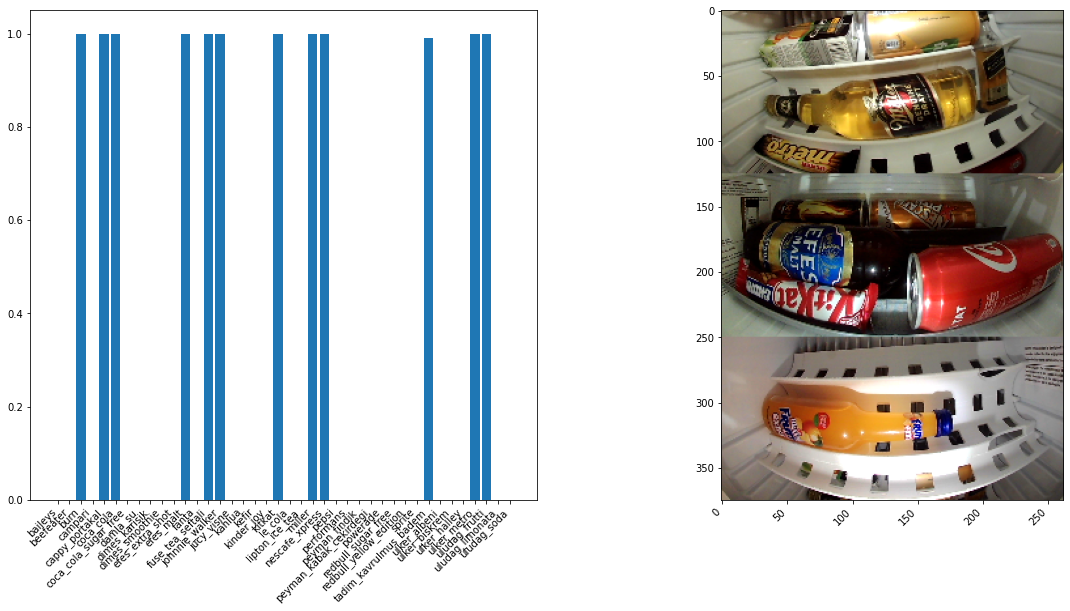

In [12]:
fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].bar(list(test_generator.class_indices.keys()), list(prediction[0]))
ax[1].imshow(test_img_visible)
fig.autofmt_xdate(rotation=45)
plt.show()

---
This section is intented to examine a single random image from the image data generator. Let me explain the plots in detail.

- First we visaully see the sample.
- In the bottom of the image we see bar chart where in the x axis we see the every product label. For each class/product we plot 3 bars.
    - blue bar is the actual perecantage prediction probability value of existance of the product
    - orange is the binary of prediction. Means we assume the probaility of existtance of product is above .5 we set this value as 1 else 0
    - green is the ground truth. It is either 1 or 0
- the last plot is the confusion matrix. It counts the binary prediction and the ground truth how model is confused.


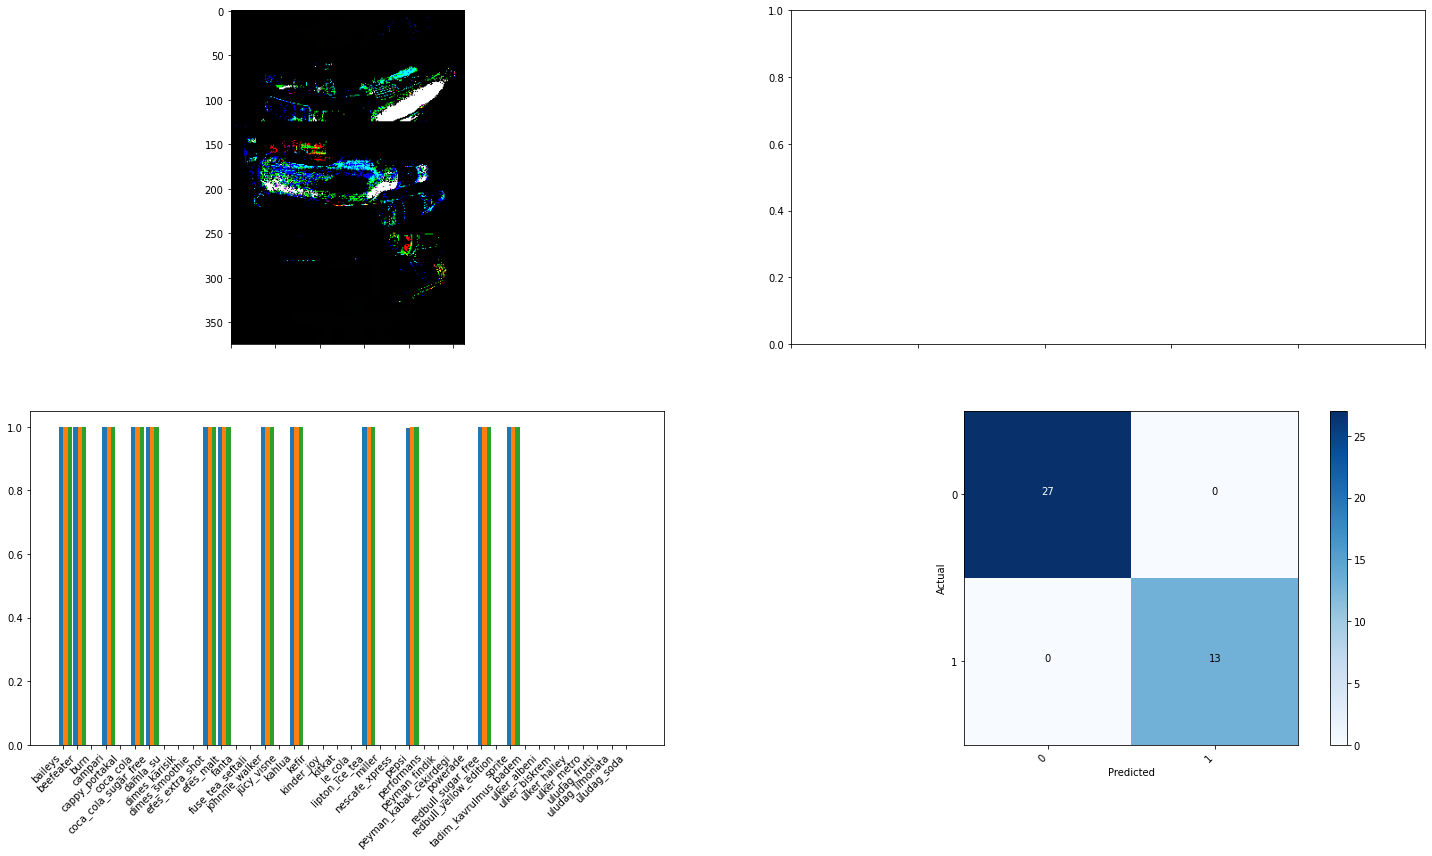

In [120]:
img_batch,ground_truth = test_generator.next()
test_img_visible = img_batch[0].astype('uint8')
prediction = model.predict(img_batch)
prediction_binary = np.round(prediction)

fig, ax = plt.subplots(2,2,figsize=(25,15))

#visualization of sample
ax[0,0].imshow(test_img_visible)

#barchart of prediction binary prediction and ground truth
dim = 3
w = 0.9
dimw = w / dim
x = np.arange(len(list(test_generator.class_indices.keys())))
ax[1,0].bar(x+0*dimw, list(prediction[0]),dimw)
ax[1,0].bar(x+1*dimw, list(prediction_binary[0]),dimw)
ax[1,0].bar(x+2*dimw, list(ground_truth[0]),dimw)
ax[1,0].set_xticks(x + dimw / 3) 
ax[1,0].set_xticklabels(list(test_generator.class_indices.keys()))

#confusion matrix the number of actual and prediction existance counts.
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(ground_truth[0], np.round(prediction[0]))
cm_plot = ax[1,1].imshow(cm,cmap=plt.cm.Blues,interpolation='nearest')
fig.colorbar(cm_plot,ax=ax[1,1], orientation='vertical')
ax[1,1].set_xlabel('Predicted')
ax[1,1].set_ylabel('Actual')
ax[1,1].set_xticks([0,1])
ax[1,1].set_yticks([0,1])
for i,row in enumerate(cm):
    for j,cell in enumerate(row):
        ax[1,1].text(j,i,format(cm[i,j],'d'),horizontalalignment='center',color='white'if cm[i,j] >cm.max() / 2. else 'black')


fig.autofmt_xdate(rotation=45)
plt.show()

In [113]:
labels = list(test_generator.class_indices.keys())
master_confusion_matrix = np.zeros((len(labels),len(labels)+1),dtype=int)
ground_truth_int = ground_truth[0].astype(int)
prediction_binary = np.round(prediction[0])
for j in range(len(ground_truth_int)):
    if ground_truth_int[j] == 1 and ground_truth_int[j] == prediction_binary[j]:
        master_confusion_matrix[j,j] += 1
    if ground_truth_int[j] == 1 and ground_truth_int[j] != prediction_binary[j]:            
        for k in range(len(prediction_binary)):
            if prediction_binary[k] == 1 and ground_truth_int[k] == 0:
                master_confusion_matrix[j,k] += 1

In [70]:
master_confusion_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

---
In this section, we are going to squeze all product into single confusion matrix. And show the number of ground truths and predictions. 

In [35]:
labels = list(test_generator.class_indices.keys())
master_confusion_matrix = np.zeros((len(labels),len(labels)+1))
for i in range(len(test_generator)):
    img_batch,ground_truth = test_generator.next()
    ground_truth = ground_truth[0].astype(int)
    prediction = model.predict(img_batch)
    prediction_binary = np.round(prediction[0])
    for j in range(len(ground_truth)):
        if ground_truth[j] == 1 and ground_truth[j] == prediction_binary[j]:
            master_confusion_matrix[j,j] += 1
        if ground_truth[j] == 1 and ground_truth[j] != prediction_binary[j]:            
            for k in range(len(prediction)):
                if prediction_binary[k] == 1 and ground_truth[k] == 0:
                    master_confusion_matrix[j,k] += 1


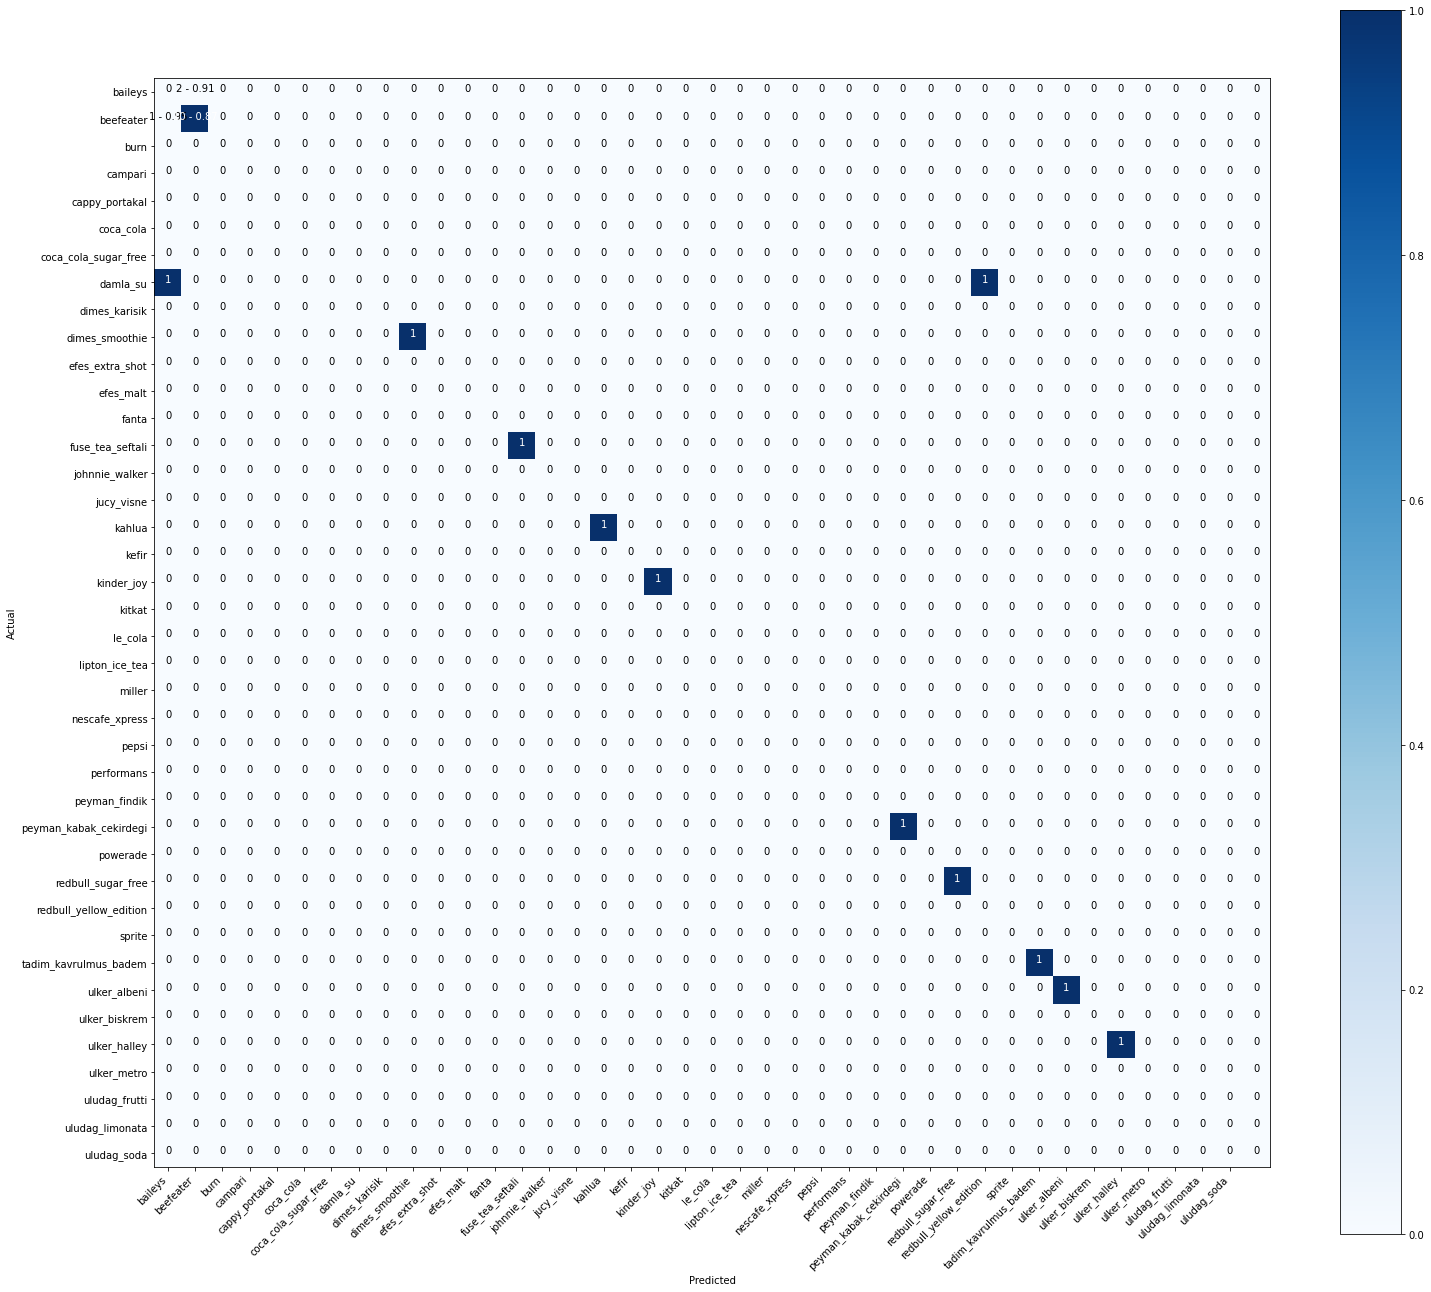

In [116]:
fig=plt.figure(figsize=(25, 25))
plt.imshow(master_confusion_matrix,cmap=plt.cm.Blues,interpolation='nearest')
plt.colorbar(orientation='vertical')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(ticks=range(len(labels)),labels=labels)
plt.yticks(ticks=range(len(labels)),labels=labels)
for i,row in enumerate(master_confusion_matrix):
    for j,cell in enumerate(row):
        val_text = "%d"%(master_confusion_matrix[i,j])
        if i == 1 and j == 0:
            val_text = "%d - %.2f"%(cm[i,j],recall)
        if i == 0 and j == 1:
            val_text = "%d - %.2f"%(cm[i,j],precision)
        if i == 1 and j == 1:
            val_text = "%d - %.2f"%(cm[i,j],mean_iou)
        plt.text(j,i,val_text,horizontalalignment='center',color='white'if master_confusion_matrix[i,j] >master_confusion_matrix.max() / 2. else 'black')



fig.autofmt_xdate(rotation=45)
plt.show()
